In [139]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error
import math

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [33]:
df.head()

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727


In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [4]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [157]:
x_train.shape

(90752, 2)

In [68]:
EMBEDDING_SIZE = 50
model = Sequential([
        layers.Embedding(
        num_movies,
        EMBEDDING_SIZE,
        embeddings_initializer="he_normal",
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        input_length=2
    ),
    layers.Flatten(),
    layers.Dense(1),
    layers.Activation('sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

In [69]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 17s 11ms/step - loss: 0.6087 - val_loss: 0.6026
Epoch 2/5
1418/1418 [==============================] - 16s 11ms/step - loss: 0.5948 - val_loss: 0.6031
Epoch 3/5
1418/1418 [==============================] - 16s 11ms/step - loss: 0.5924 - val_loss: 0.6027
Epoch 4/5
1418/1418 [==============================] - 15s 11ms/step - loss: 0.5914 - val_loss: 0.6030
Epoch 5/5
1418/1418 [==============================] - 15s 11ms/step - loss: 0.5909 - val_loss: 0.6030


In [67]:
ratings = model.predict(user_movie_array).flatten()
ratings.shape

262/262 [==============================] - 0s 2ms/step


(8378,)

In [82]:
user_id = df.userId.sample(1).iloc[0]

ratings_pd = pd.DataFrame(index = range(len(ratings)),columns=['Similarity'])

ratings_pd['Similarity'] = ratings 

ratings_pd = ratings_pd.sort_values(by="Similarity",ascending=False)

print('Similarity matrix for user with id: ' + str(user_id))
ratings_pd

Similarity matrix for user with id: 380


,Similarity
5980,0.911473
4319,0.901306
7522,0.893864
7589,0.888151
4526,0.885160
...,...
3670,0.198182
2784,0.197715
6112,0.192980
7826,0.175570


In [91]:
n = 10
similar_users = []
for row in ratings_pd.iterrows(): 
    curr_user_id = int(df.iloc[row[0]]['userId'])
    if(curr_user_id != user_id and curr_user_id not in similar_users):
        similar_users.append(curr_user_id)
    if(len(similar_users) == n):
        break
print(str(n) + ' similar users for user with id: ' + str(user_id))
print(str(similar_users))

10 similar users for user with id: 380
[298, 608, 555, 256, 62, 554, 379, 606, 573, 66]


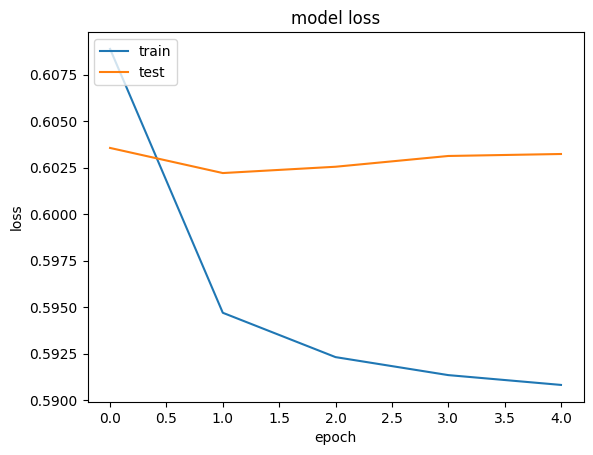

In [38]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [37]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

262/262 [==============================] - 0s 2ms/step
Showing recommendations for user: 274
Movies with high ratings from user
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
American Beauty (1999) : Drama|Romance
Fight Club (1999) : Action|Crime|Drama|Thriller
Eternal Sunshine of the Spotless Mind (2004) : Drama|Romance|Sci-Fi
Inglourious Basterds (2009) : Action|Drama|War
--------------------------------
Top 10 movie recommendations
--------------------------------
Guess Who's Coming to Dinner (1967) : Drama
Trial, The (Procès, Le) (1962) : Drama
Come and See (Idi i smotri) (1985) : Drama|War
Adam's Rib (1949) : Comedy|Romance
Bad Boy Bubby (1993) : Drama
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997) : Action|Animation|Drama|Fantasy|Sci-Fi
Memories of Murder (Salinui chueok) (2003) : Crime|Drama|Mystery|Thriller
Day of the Doctor, The (2013) : Adventure|Drama|Sci-Fi
Band of Brothe

In [154]:
rmse = 0

for similar_user_id in similar_users:
    df_user = movies_watched_by_user[['movieId', 'rating']]
    movies_watched_by_similar_user = df[df.userId == similar_user_id]
    df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
    corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']
    for movie_id in corresponding_movie_ids:
        rmse += math.pow(df_user[df_user.movieId == movie_id].iloc[0]['rating'] - 
                         df_similar_user[df_similar_user.movieId == movie_id].iloc[0]['rating'],2)
    rmse = math.sqrt(rmse*1/n)
    print(str(rmse) + str(corresponding_movie_ids.shape))

10.115582039606025(374,)
8.65659044912953(424,)
5.388938582403121(183,)
3.903702583220232(107,)
5.33763714187486(226,)
2.9847552184706014(41,)
2.7746126796090045(25,)
5.7164203193922765(238,)
4.939295702014532(223,)
4.0919346976951445(149,)


In [137]:
corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]
corresponding_movie_ids

,movieId,rating
45249,77561,3.5
45079,48780,2.0
45390,106489,3.5
44915,6503,1.0
45351,96737,3.0
...,...,...
45272,81834,3.0
44859,5419,1.0
44547,173,2.0
45002,8969,1.0
